In [1]:
%%capture
!pip install datasets evaluate multimolecule==0.0.5

In [2]:
import os
import pandas as pd
import torch
from transformers import (
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
from google.colab import drive

import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

WORKING_DIRECTORY = '/content/drive/MyDrive/Machine Learning (CS-433)/Project 2'
DATASET_PATH = 'data/dataset.txt'

%cd {WORKING_DIRECTORY}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Machine Learning (CS-433)/Project 2


In [4]:
from BP_LM.scripts.data_preprocessing import *
from BP_LM.scripts.trainer_datasets_creation import create_dataset
from BP_LM.scripts.compute_metrics_proposal import compute_metrics, precision_recall_data
from BP_LM.scripts.model_choice import set_multimolecule_model

os.environ["WANDB_MODE"] = "disabled"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Model and dataset variables

MULTIMOLECULE_MODEL = "splicebert" # Available models are: rnafm, rnamsm, ernierna, utrlm-te_el, splicebert, rnabert.
SAMPLE_N_DATAPOINTS = 25000  # Set to None to use the full dataset
SEED = 32

# Training hyperparameters

BATCH_SIZE = 16
LEARNING_RATE = 2e-5
TRAIN_EPOCHS = 3
WEIGHT_DECAY = 0.01 #Try 0.01
OPTIMIZER = "adamw_torch"
MODEL_OUTPUT_DIRECTORY = f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure"
LOGGING_STEPS = 100 # Number of steps between each logging of eval metrics (set big to reduce training time)

In [6]:
# Initialize the selected multimolecule model
model, tokenizer, MODEL_MAX_INPUT_SIZE = set_multimolecule_model(MULTIMOLECULE_MODEL)

# Load data and create dataset
df = pd.read_csv(DATASET_PATH, sep='\t')
train_dataset, val_dataset, test_dataset = create_dataset(df, tokenizer, model, MODEL_MAX_INPUT_SIZE, SEED, SAMPLE_N_DATAPOINTS)

# Set up data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/78.9M [00:00<?, ?B/s]

Some weights of SpliceBertForTokenPrediction were not initialized from the model checkpoint at multimolecule/splicebert and are newly initialized: ['splicebert.pooler.dense.bias', 'splicebert.pooler.dense.weight', 'token_head.decoder.bias', 'token_head.decoder.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Chromosomes in train set: {'chr19', 'chr2', 'chr17', 'chrY', 'chr1', 'chr6', 'chrX', 'chr7', 'chr12', 'chr14', 'chr16', 'chr13', 'chr20', 'chr5', 'chr4', 'chr21', 'chr22', 'chr3', 'chr18', 'chr15'}
Chromosomes in validation set: {'chr9', 'chr10'}
Chromosomes in test set: {'chr8', 'chr11'}

Total data points: 25000
Train set contains 20758 data points (83.03%)
Validation set contains 1961 data points (7.84%)
Test set contains 2281 data points (9.12%)


In [7]:
# Define model training parameters

training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIRECTORY,
    eval_strategy="steps",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=TRAIN_EPOCHS,
    optim=OPTIMIZER,
    weight_decay=WEIGHT_DECAY,
    load_best_model_at_end=False,
    metric_for_best_model="F1",
    logging_strategy="steps",
    logging_steps=LOGGING_STEPS,
)

#Define metrics function
metrics_fn = lambda x: compute_metrics(x, "test_metrics")

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=metrics_fn,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-7-575b92ef3404>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,F1,Seq Accuracy,Ap,Mcc,Auc,Ideal Threshold
100,0.157600,0.058654,0.011566,0.002040,0.004956,0.038309,0.661780,0.010394
200,0.074300,0.056480,0.017206,0.000000,0.006711,0.058451,0.722444,0.007425
300,0.071800,0.055548,0.020948,0.000000,0.007916,0.071969,0.764598,0.006093
400,0.067700,0.054931,0.023723,0.000000,0.008837,0.078251,0.772481,0.005178
500,0.069200,0.054488,0.026812,0.000000,0.009799,0.092046,0.824252,0.004505
600,0.068300,0.054145,0.030168,0.000510,0.010754,0.097616,0.822478,0.004029
700,0.068900,0.053787,0.033502,0.000510,0.011758,0.110018,0.863001,0.003864
800,0.070300,0.051246,0.037394,0.005099,0.012847,0.109330,0.822571,0.028223
900,0.063300,0.047753,0.057094,0.023967,0.016108,0.152707,0.899514,0.139183
1000,0.061000,0.046465,0.544563,0.331464,0.370652,0.548062,0.740126,0.495251


TrainOutput(global_step=3894, training_loss=0.0638570492856614, metrics={'train_runtime': 907.8112, 'train_samples_per_second': 68.598, 'train_steps_per_second': 4.289, 'total_flos': 3669054470369280.0, 'train_loss': 0.0638570492856614, 'epoch': 3.0})

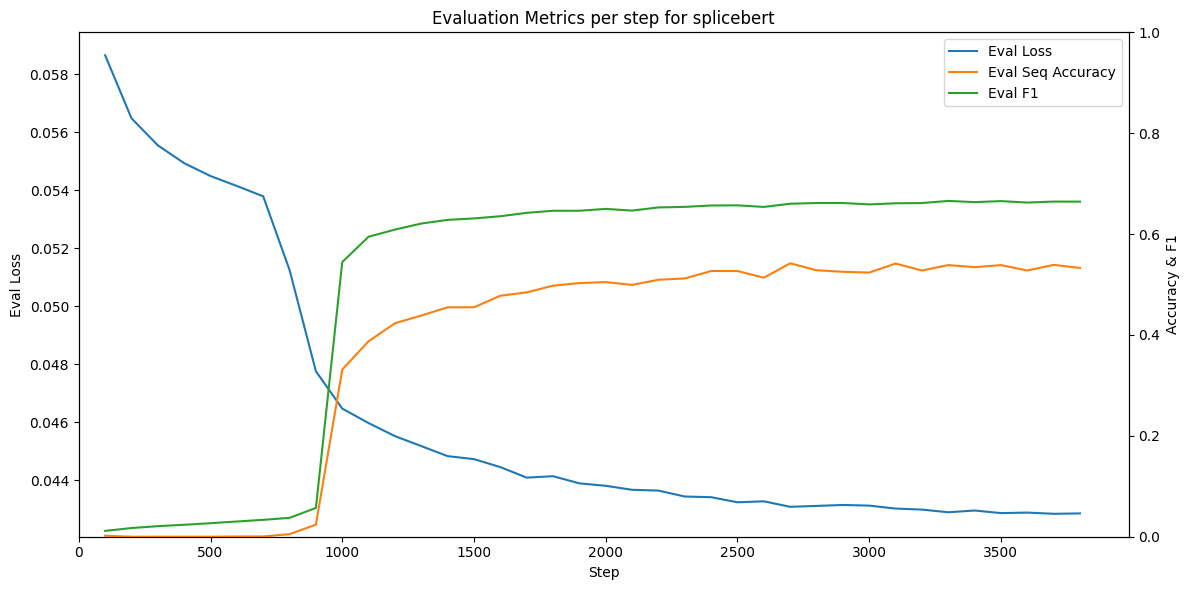

In [8]:
log_history = trainer.state.log_history

eval_entries = [entry for entry in log_history if 'eval_loss' in entry]

data = {
    'step': [entry['step'] for entry in eval_entries],
    'eval_loss': [entry['eval_loss'] for entry in eval_entries],
    'eval_seq_accuracy': [entry['eval_seq_accuracy'] for entry in eval_entries],
    'eval_F1': [entry['eval_F1'] for entry in eval_entries]}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Step')
ax1.set_ylabel('Eval Loss')
ax1.plot(df['step'], df['eval_loss'], color="tab:blue", linestyle='-', label='Eval Loss')
ax1.tick_params(axis='y')
ax1.set_xlim(left=0)

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy & F1')
ax2.plot(df['step'], df['eval_seq_accuracy'], color='tab:orange', linestyle='-', label='Eval Seq Accuracy')
ax2.plot(df['step'], df['eval_F1'], color="tab:green", linestyle='-', label='Eval F1')
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title(f'Evaluation Metrics per step for {MULTIMOLECULE_MODEL}')

fig.tight_layout()

plt.show()



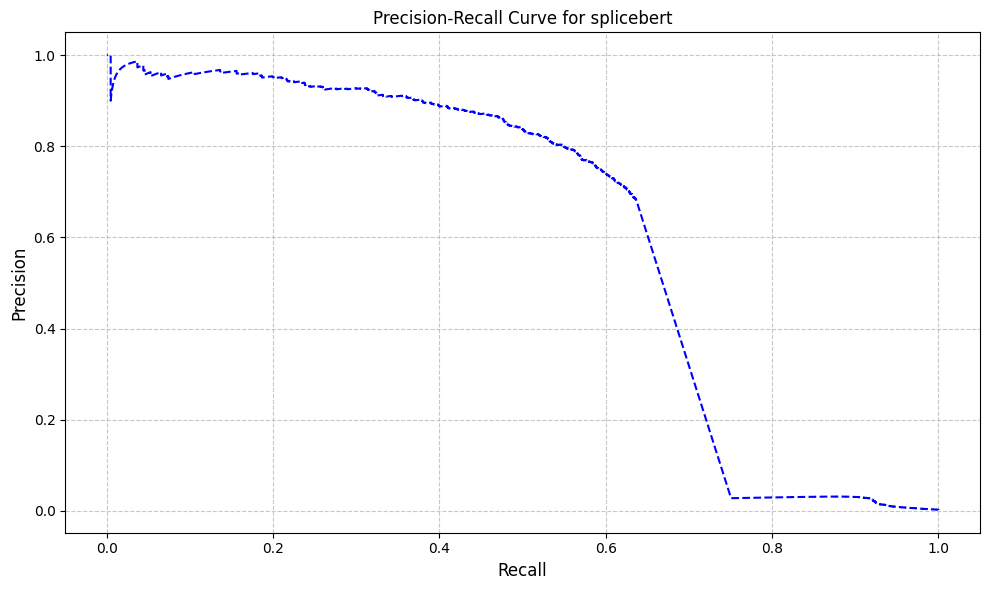

In [9]:
last_pr_curve = precision_recall_data[-1]
precision, recall = zip(*last_pr_curve)

fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
ax.plot(recall, precision, linestyle='--', color='b', label='Precision-Recall Curve')
ax.set_title(f"Precision-Recall Curve for {MULTIMOLECULE_MODEL}", fontsize=12)

ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)

ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
